In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

In [17]:
sns.set()

## What we got here, is a failure to communicate.

In [3]:
cols = ['date','time','resource','number1','number2','ip_source']

In [4]:
blob = pd.read_csv('anonymized-curriculum-access.txt', sep=' ', names=cols)

In [6]:
#Cleaning up the time data. 
Date = blob['date'] + ' ' + blob['time']
Date = pd.to_datetime(Date)
blob['Date'] = Date
blob.drop(['date','time'],axis=1,inplace=True)

In [7]:
blob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399195 entries, 0 to 399194
Data columns (total 5 columns):
resource     399195 non-null object
number1      399195 non-null int64
number2      372441 non-null float64
ip_source    399195 non-null object
Date         399195 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 15.2+ MB


In [45]:
df = blob.set_index('Date')

In [73]:
df.index

DatetimeIndex(['2018-01-26 09:55:03', '2018-01-26 09:56:02',
               '2018-01-26 09:56:05', '2018-01-26 09:56:06',
               '2018-01-26 09:56:24', '2018-01-26 09:56:41',
               '2018-01-26 09:56:46', '2018-01-26 09:56:48',
               '2018-01-26 09:56:59', '2018-01-26 09:58:26',
               ...
               '2019-11-19 10:05:00', '2019-11-19 10:05:53',
               '2019-11-19 10:06:13', '2019-11-19 10:06:21',
               '2019-11-19 10:06:26', '2019-11-19 10:06:28',
               '2019-11-19 10:06:50', '2019-11-19 10:07:03',
               '2019-11-19 10:07:07', '2019-11-19 10:07:45'],
              dtype='datetime64[ns]', name='Date', length=399195, freq=None)

#### Looks like there is just one column with some nulls. Maybe that's significant.

In [10]:
blob.number2.isnull().sum()

26754

#### Lets see if there's anything that jumps out about these null values in the number2 column

In [26]:
blob[blob.number2.isnull()].number1.unique()
#I see a coupleof consecutive series among the number1 column.

array([ 48,  54,  58,  59,  61,  62,  63,  73,  74,  78,  79,  86,  88,
        89, 100, 103, 111, 137, 166, 176, 213, 247, 317, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 372, 375, 403, 406, 429])

In [30]:
blob.ip_source.nunique()

2585

In [29]:
blob[blob.number2.isnull()].ip_source.nunique()

240

In [37]:
nulls = df[df.number2.isnull()]['number1']

Whatever these nulls mean, they were happening a lot between early this year and stops dramatically in late June

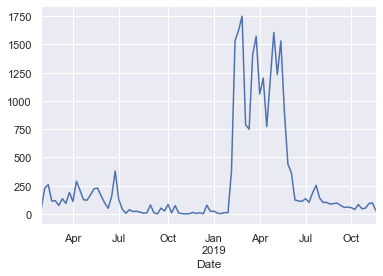

In [44]:
nulls.resample('W').count().plot()
plt.show()

The relationship between mystery number 1 and 2 shows some predictability.

In [15]:
blob.groupby('number2')['number1'].nunique()

number2
1.0     18
2.0      3
4.0      1
6.0      2
7.0      6
8.0      4
9.0      1
11.0     5
12.0     4
13.0    10
14.0    10
15.0     5
16.0     8
17.0    12
18.0    13
19.0    16
21.0    28
22.0    35
23.0    33
24.0    33
25.0    26
26.0    20
27.0    28
28.0    19
29.0    25
31.0    28
32.0    20
33.0    29
34.0    22
51.0    25
52.0    27
Name: number1, dtype: int64

The distribution of n_unique values grouped to number 2 looks to be bimodal, with 1-10 and 25-35 being the peaks.

<function matplotlib.pyplot.show(*args, **kw)>

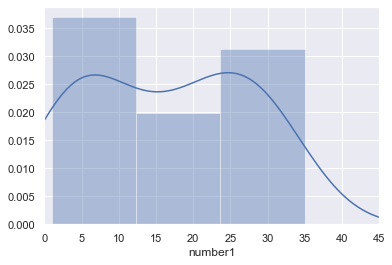

In [21]:
ax = sns.distplot(blob.groupby('number2')['number1'].nunique())
ax.set_xlim(0, 45)
plt.show

# Lets find the normal, so we can see what's an anomaly

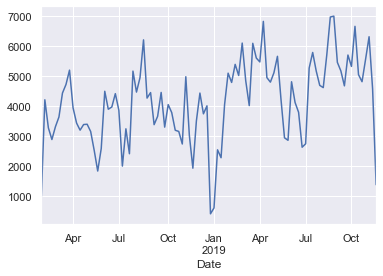

In [46]:
#The traffic on a weekly basis
df.resample('W')['ip_source'].count().plot()

In [47]:
#Each week has about 4158 hits per week
df.resample('W')['ip_source'].count().mean()

4158.28125

In [48]:
#The top twelve most common clients' IP address
df.groupby('ip_source').count().sort_values('resource',ascending=False).head(12)

,resource,number1,number2
ip_source,,,
97.105.19.58,227220,227220,211289
97.105.19.61,61662,61662,60530
192.171.117.210,8127,8127,7791
70.122.40.62,1338,1338,1338
66.69.108.117,1199,1199,1199
173.174.211.206,1019,1019,1019
108.65.244.91,1007,1007,1007
170.248.173.245,997,997,952
67.11.157.190,972,972,968


97.105.19.X is traffic from the Codeup Router

In [49]:
clients = df.ip_source

In [53]:
local_traffic = df[(df.ip_source == '97.105.19.58') | (df.ip_source =='97.105.19.61')]

In [55]:
outside_traffic = df[(df.ip_source != '97.105.19.58') | (df.ip_source != '97.105.19.61')]

Looks like the traffic getting to the curricullum is paired. No real diffenrences between them

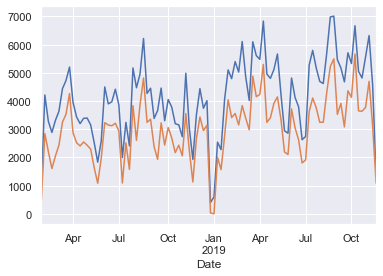

In [61]:
outside_traffic.resample('W')['ip_source'].count().plot()
local_traffic.resample('W')['ip_source'].count().plot()
plt.show()

## They shoot cohorts, don't they

In [62]:
first_cohort = df[df.number2 == 1]
last_cohort = df[df.number2 == 51]

If number2 does correspond to the cohorts accessing the curriculum, the plots would indicate so.

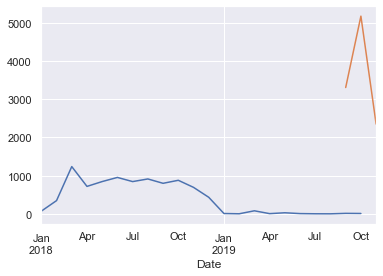

In [72]:
first_cohort.resample('M')['ip_source'].count().plot()
last_cohort.resample('M')['ip_source'].count().plot()

## Maybe Bayes?

In [66]:
bayes = df[df.number2 == 34]

I think we started with 22 students in Bayes

In [68]:
bayes.number1.nunique()

22

Data for this possible Bayes cohort is consistent with the start date

(2509, 2600)

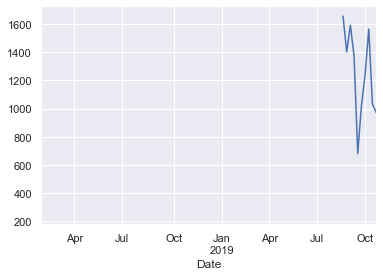

In [74]:
ax = bayes.resample('W')['ip_source'].count().plot()
ax.set_xlim('2018-01-26', '2019-10-26')

Maybe Sean?

In [ ]:
#bayes.groupby('number1')['resource'].count()
# bayes.pivot_table(values = 'resource', index='number1', columns='ip_source')

In [75]:
sean = df[df.number1 == 358]

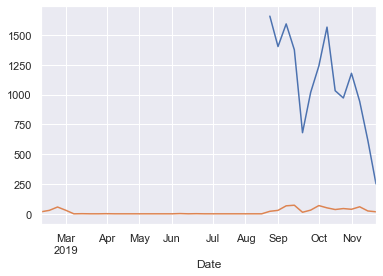

In [89]:
ax = bayes.resample('W')['ip_source'].count().plot()
ax.set_xlim('2018-01-26', '2019-10-26')
sean.resample('W')['ip_source'].count().plot()

## Instructors?

In [93]:
df.resource.unique()

array(['/', 'java-ii', 'java-ii/object-oriented-programming', ...,
       '9-timeseries/5.1-modeling-lesson1',
       '9-timeseries/5.2-modeling-lesson2', 'alumni'], dtype=object)

In [99]:
javascript = df[df.resource.str.match('javascript')]

In [98]:
time_series = df[df.resource.str.match('9-timeseries')]

In [100]:
javascript.number1.nunique()

417

I'm willing to bet 11, 146, 248 and 1 are instructors

In [102]:
time_series.number1.unique()

array([404,  11, 467, 485, 471, 354, 363, 403, 353, 248, 481, 349, 484,
       476, 479,   1, 429, 469, 478, 146, 369, 351, 361, 483, 468, 480,
       482, 474, 470, 477, 475, 473, 358, 466, 472])

In [108]:
df[df.number1 == 248].head()

,resource,number1,number2,ip_source
Date,,,,
2018-09-05 14:28:23,/,248,1.0,97.105.19.58
2018-09-07 14:53:23,/,248,1.0,97.105.19.58
2018-09-07 14:54:13,html-css,248,1.0,97.105.19.58
2018-09-07 14:56:07,html-css/introduction,248,1.0,97.105.19.58
2018-09-07 14:57:00,html-css/elements,248,1.0,97.105.19.58


In [109]:
df[df.number1 == 248].tail()

,resource,number1,number2,ip_source
Date,,,,
2019-11-19 09:45:31,10-anomaly-detection/exercises,248,28.0,97.105.19.58
2019-11-19 09:45:38,10-anomaly-detection/2-detecting-through-proba...,248,28.0,97.105.19.58
2019-11-19 09:46:05,10-anomaly-detection/3-detecting-timeseries-an...,248,28.0,97.105.19.58
2019-11-19 09:46:09,10-anomaly-detection/4-detecting-with-clustering,248,28.0,97.105.19.58
2019-11-19 09:46:55,10-anomaly-detection/2-detecting-through-proba...,248,28.0,97.105.19.58


Whoever 248 is, they're making requests to the curricullum from the internal traffic address.

## USING SOME DATA THAT GARRETT PUT TOGETHER

In [ ]:
IP_DF = pd.read_csv('/Users/fredricklambuth/Downloads/GEOs', header=None)

In [ ]:
geoDF = pd.read_csv('/Users/fredricklambuth/Downloads/IPs', header=None)

In [ ]:
geoDF['IP'] = IP_DF[0]

In [ ]:
geoDF = geoDF.rename(columns={0: "State", 1: "City", 2: "Org"})

In [ ]:
geoDF.City = geoDF.City.str.strip("'")

In [ ]:
geoDF